In [1]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import kerastuner as kt
from kerastuner.tuners import Hyperband
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA, ALPHABET_PROTEIN
from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    one_hot_encode_classes,
    split_train_test_set,
    combine_sequences,
)
from rna_learn.hyperband import hyperband_densenet_model

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

## Hyperband optimisation results

In [3]:
hyperband_run_id = 'run_r0cvl_top10'

build_model_fn = hyperband_densenet_model(n_inputs=len(ALPHABET_PROTEIN))

hypermodel = Hyperband(
    build_model_fn,
    max_epochs=100,
    objective=kt.Objective('val_loss', 'min'),
    factor=3,
    hyperband_iterations=1,
    project_name=f'hyperband_logs/protein/{hyperband_run_id}',
)

INFO:tensorflow:Reloading Oracle from existing project ./hyperband_logs/protein/run_r0cvl_top10/oracle.json
INFO:tensorflow:Reloading Tuner from ./hyperband_logs/protein/run_r0cvl_top10/tuner0.json


In [4]:
best_model_idx = 2

In [5]:
best_hyperparameters_sets = hypermodel.get_best_hyperparameters(10)

In [6]:
best_hyperparameters = best_hyperparameters_sets[best_model_idx]

In [7]:
best_hyperparameters.values

{'n_layers': 14,
 'growth_rate': 18,
 'l2_reg': 1e-05,
 'learning_rate': 0.0005,
 'kernel_size_l1': 2,
 'kernel_size_l2': 6,
 'kernel_size_l3': 8,
 'kernel_size_l4': 3,
 'kernel_size_l5': 2,
 'kernel_size_l6': 4,
 'kernel_size_l7': 8,
 'kernel_size_l8': 4,
 'kernel_size_l9': 4,
 'kernel_size_l10': 8,
 'kernel_size_l11': 3,
 'kernel_size_l12': 6,
 'kernel_size_l13': 7,
 'kernel_size_l14': 6,
 'kernel_size_l15': 9,
 'kernel_size_l16': 4,
 'kernel_size_l17': 10,
 'kernel_size_l18': 8,
 'kernel_size_l19': 6,
 'kernel_size_l20': 4,
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '39abd919cb485f6e464ca205e8534cf5'}

In [8]:
print(f'Learning rate:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['learning_rate']
    print(f'{i+1:2d}: {l:.0e}')

Learning rate:
 1: 1e-03
 2: 5e-04
 3: 5e-04
 4: 1e-03
 5: 1e-03
 6: 5e-04
 7: 5e-04
 8: 1e-03
 9: 5e-04
10: 1e-03


In [9]:
print(f'L2 regularization:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['l2_reg']
    print(f'{i+1:2d}: {l:.0e}')

L2 regularization:
 1: 1e-05
 2: 1e-05
 3: 1e-05
 4: 1e-05
 5: 5e-06
 6: 5e-06
 7: 1e-05
 8: 5e-06
 9: 5e-05
10: 1e-05


In [10]:
print(f'Number of layers:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['n_layers']
    print(f'{i+1:2d}: {l:2d}')

Number of layers:
 1: 16
 2: 16
 3: 14
 4: 16
 5: 20
 6: 12
 7: 14
 8: 20
 9: 12
10: 16


In [11]:
print(f'Growth rate:')
for i in range(10):
    l = best_hyperparameters_sets[i].values['growth_rate']
    print(f'{i+1:2d}: {l:2d}')

Growth rate:
 1: 18
 2: 16
 3: 18
 4: 18
 5:  8
 6: 12
 7: 18
 8:  8
 9: 18
10: 18


In [12]:
print(f'Kernel size (layer 1)')
for i in range(10):
    l = best_hyperparameters_sets[i].values['kernel_size_l1']
    print(f'{i+1:2d}: {l:2d}')

Kernel size (layer 1)
 1:  6
 2:  2
 3:  2
 4:  6
 5:  5
 6:  5
 7:  2
 8:  5
 9:  6
10:  6


In [13]:
best_trial_id = best_hyperparameters.values['tuner/trial_id']
best_trial_id

'39abd919cb485f6e464ca205e8534cf5'

In [14]:
trials = hypermodel.oracle.get_best_trials(10)
best_model = hypermodel.load_model(trials[best_model_idx])

In [15]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 18)     738         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 38)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 18)     4122        concat_1[0][0]               

In [16]:
logits_model = tf.keras.Model(inputs=best_model.inputs, outputs=best_model.get_layer('logits').output)

In [17]:
model_output_path = os.path.join(os.getcwd(), f'hyperband_logs/protein/{hyperband_run_id}/best_model.h5')
logits_model.save(model_output_path)

## Best model evaluation

In [18]:
train_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_train.csv')
test_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_full_test.csv')

train_df = pd.read_csv(train_set_path)
dataset_df = pd.read_csv(test_set_path)

In [19]:
alphabet = ALPHABET_PROTEIN
y_train = train_df['temperature'].values.astype('float64')
mean, std = np.mean(y_train), np.std(y_train)

raw_sequences = np.array([
    s[:-1]  # Removing stop amino acid at the end
    for s in dataset_df['amino_acid_sequence'].values
])

x_protein = sequence_embedding(raw_sequences, alphabet, dtype='float32')

y = dataset_df['temperature'].values.astype('float32')
y_norm = normalize(y, mean, std)

In [20]:
#%%time
#best_model.evaluate(x_protein, y_norm, verbose=0)

In [21]:
%%time
b = int(np.ceil(len(x_protein) / 30))
y_mean = []
for idx in range(30):
    x_ = x_protein[idx * b:(idx + 1) * b]
    y_hat_ = best_model(x_)
    y_mean_ = denormalize(y_hat_.mean().numpy(), mean, std).flatten().tolist()
    y_mean += y_mean_

y_mean = np.array(y_mean)

CPU times: user 8min 17s, sys: 2min 53s, total: 11min 11s
Wall time: 1min 46s


In [22]:
mae = np.mean(np.abs(y_mean.flatten() - y))
rmse = np.sqrt(np.mean((y_mean.flatten() - y) **2))
correlation = np.corrcoef(y, y_mean.flatten())[0, 1]

print(f'Mean Absolute Error    = {mae:.2f}')
print(f'Root Mean Square Error = {rmse:.2f}')
print(f'Correlation            = {correlation:.2f}')

Mean Absolute Error    = 9.31
Root Mean Square Error = 11.79
Correlation            = 0.76


In [23]:
def predictions_per_specie(dataset_df, y_true, y_pred):
    y_species_pred = []
    y_species_actual = []
    y_species_pred_std  = []
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        indices = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id].index
        
        truth = y_true[indices[0]]
        prediction = np.mean(y_pred[indices])
        prediction_std = np.std(y_pred[indices])
        
        y_species_actual.append(truth)
        y_species_pred.append(prediction)
        y_species_pred_std.append(prediction_std)
    
    return np.array(y_species_actual), np.array(y_species_pred), np.array(y_species_pred_std)

In [24]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [25]:
y_species_actual, y_species_pred, y_species_pred_std = predictions_per_specie(dataset_df, y, y_mean)

In [26]:
mae_species = np.mean(np.abs(y_species_pred.flatten() - y_species_actual))
rmse_species = np.sqrt(np.mean((y_species_pred.flatten() - y_species_actual) **2))
corr_species = np.corrcoef(y_species_actual, y_species_pred.flatten())[0, 1]

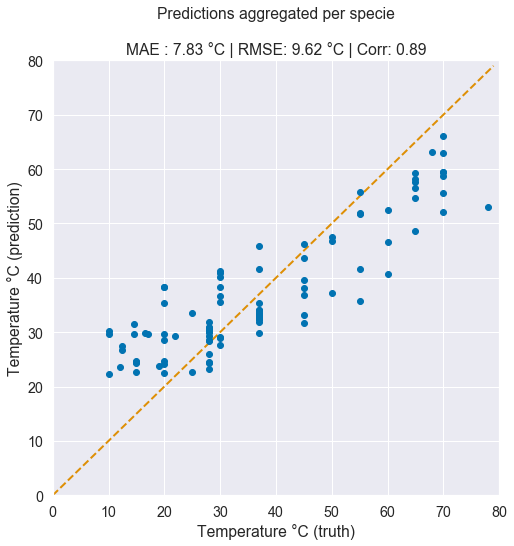

In [27]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred);
title = f'Predictions aggregated per specie\n\n'
title += f'MAE : {mae_species:.2f} °C | '
title += f'RMSE: {rmse_species:.2f} °C | '
title += f'Corr: {corr_species:.2f}'
ax.set_title(title);

### Results per gene

In [28]:
def mae_per_gene(dataset_df, y_true, y_pred, plot_top=20):
    f, ax = plt.subplots(1, 1, figsize=(6, 12))
    palette = sns.color_palette()
    
    genes = np.array(sorted(dataset_df['gene_name'].unique().tolist()))
    
    results = []
    for i, gene in enumerate(genes):
        df = dataset_df[dataset_df['gene_name'] == gene]
        indices = df.index

        y_p = y_pred[indices]
        y_t = y_true[indices]
        
        results.append(np.mean(np.abs(y_p - y_t)))
    
    sorted_idx = np.argsort([np.sum(r) for r in results]).tolist()
    sorted_maes = np.array(results)[sorted_idx]
    
    cm = pd.DataFrame(
        sorted_maes[:plot_top], 
        index=[f'{g}' for i, g in enumerate(genes[sorted_idx][:plot_top])],
        columns=[''],
    )
    sns.heatmap(cm, cmap="Greys_r", annot=True, fmt='.2f', cbar=False, ax=ax);
    plt.yticks(rotation=0)
    ax.set_title('Mean average error (°C)')
    
    return f, ax, genes[sorted_idx], sorted_maes

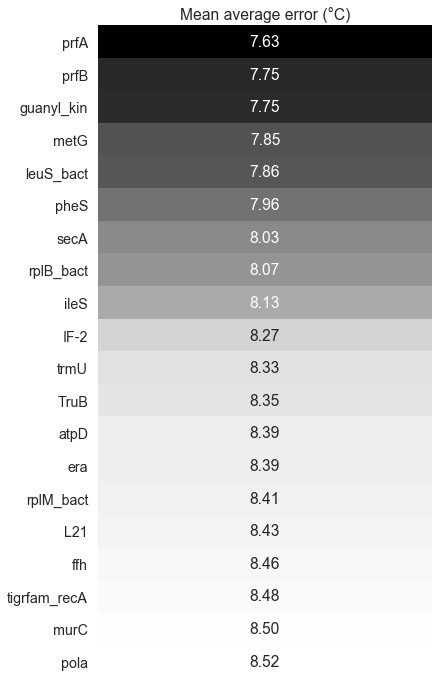

In [29]:
_, _, sorted_genes, sorted_gene_maes = mae_per_gene(dataset_df, y, y_mean.flatten(), plot_top=20)

In [30]:
sorted_genes[-10:], sorted_gene_maes[-10:]

(array(['RNAse_H_YqgF', 'GTPase_EngA', 'TIGR00095', 'dnan', 'nusB',
        'secE_bact', 'secG', 'RNaseIII', 'TIGR00043', 'ruvA'], dtype='<U15'),
 array([10.53925056, 10.55863831, 10.58744246, 10.66120161, 10.71261463,
        10.78642833, 11.1008378 , 11.19591528, 11.28971086, 11.69173896]))

## IVYWREL

In [31]:
def get_IVYWREL_content_per_specie(dataset_df):
    IVYWREL_content = []
    
    letters = {'I', 'V', 'Y', 'W', 'R', 'E', 'L'}
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        sequences = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id]['amino_acid_sequence'].values
        
        sequence_str = ''
        for sequence in sequences:
            sequence_str += str(sequence)
        
        length = len(sequence_str)
        n = len([b for b in sequence_str if b in letters])
        IVYWREL_content.append(n / length)
    
    return np.array(IVYWREL_content)

In [32]:
IVYWREL_content = get_IVYWREL_content_per_specie(dataset_df)

In [33]:
def fit_line(y_species_actual, IVYWREL_content):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    X_bins = sm.add_constant(IVYWREL_content[:,np.newaxis])
    model = sm.OLS(y_species_actual, X_bins)

    results = model.fit()

    p_value = results.f_pvalue

    a = results.params[1]
    b = results.params[0]
    y_fit = a * IVYWREL_content + b
    
    ax.plot(IVYWREL_content, y_species_actual, 'o', color=palette[0], label='actual')
    ax.plot(IVYWREL_content, y_fit, color=palette[1], linewidth=1, label=f'p = {p_value:.1e}')
    
    ax.set_xlabel('IVYWREL content')
    ax.set_ylabel('Optimal Growth Temperature °C')
    ax.legend()
    
    ax.set_title('IVYWREL vs OGT')
    
    return a, b, y_fit, p_value

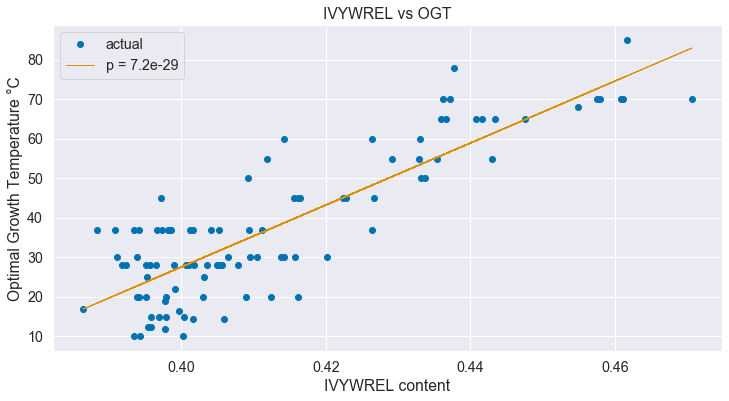

In [34]:
a, b, y_fit, p_value = fit_line(y_species_actual, IVYWREL_content)

In [35]:
mae_IVYWREL = np.mean(np.abs(y_fit - y_species_actual))
rmse_IVYWREL = np.sqrt(np.mean((y_fit - y_species_actual) **2))
corr_IVYWREL = np.corrcoef(y_species_actual, y_fit)[0, 1]

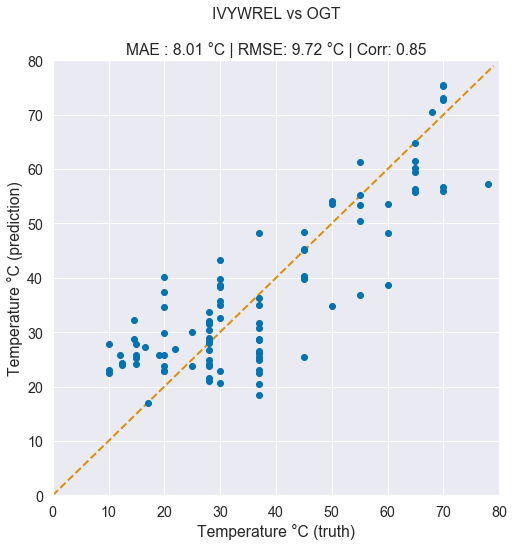

In [36]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_fit);
title = f'IVYWREL vs OGT\n\n'
title += f'MAE : {mae_IVYWREL:.2f} °C | '
title += f'RMSE: {rmse_IVYWREL:.2f} °C | '
title += f'Corr: {corr_IVYWREL:.2f}'
ax.set_title(title);